<a href="https://colab.research.google.com/github/mcaniglia16/Breast-Cancer-Lab/blob/master/src/project4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP 551 Project 4 

## Team Member

* Le-Li Mao (260800098)
* Enan Ashaduzzaman()
* Marco Caniglia (260929489)

## Intialize Dependency

Import all required dependency

In [93]:
# requirements
import torch
import torch.nn as nn
import torchvision
import numpy as np

# colab requirements
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep

# Status tracking
from tqdm.notebook import tqdm

# Backup directory checking.
import os

In [94]:
# Initialize the google drive (optional) for backup and saving results
# Make sure you create a folder called data and within it there is a backup folder
from google.colab import drive
drive.mount('/content/drive', timeout_ms=20000)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Initialize constants For training and data detail

In [95]:
# image data
img_size = 32
n_channels = 1 #change to 3 for CIFAR
# n_channels = 3
img_coords = 2

# training info
lr = 1e-4
batch_size = 64
nz = 48 #test with 24, 48, 96 with MNIST -> plot diff
ngf = 32
kernel_size = 4 #test 1,2,3,4 with MNIST -> plot on same graph
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Backup info (Optional)
backup_folder = '/content/drive/My Drive/data/backup'
backup_name = 'GON-temp'

## Load Data

Initialize Training Loader

In [87]:
#MNIST DATASET
train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))

#CIFAR10 DATASET
# train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
#         torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
#     ]))

train_loader = torch.utils.data.DataLoader(train_dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)

Initialize Validation Loader

In [88]:
#MNIST DATASET
validation_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))

#CIFAR10
# validation_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
#         torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
#     ]))

validation_loader = torch.utils.data.DataLoader(validation_dataset, sampler=None, batch_size=batch_size)

Preview the data

In [89]:
def preview_dataloader(loader):
  images, labels = next(iter(loader))
  print(f'Images Shape: {images.shape}')
  print(f'Label Shape: {labels.shape}')
  training_imgs = torchvision.utils.make_grid(images, padding=0, nrow=8)
  training_imgs = training_imgs.permute(1, 2, 0)    #for CIFAR10
  plt.title("Training Dataset Preview")
  # plt.imshow(training_imgs[0,:,:].data.numpy())
  plt.imshow(training_imgs.data.numpy())            #for CIFAR10
  sleep(1)
  print('First row labels')
  print(list(map(lambda x: x.item(), labels[:8])))

Images Shape: torch.Size([64, 1, 32, 32])
Label Shape: torch.Size([64])
First row labels
[2, 6, 4, 0, 8, 5, 2, 3]


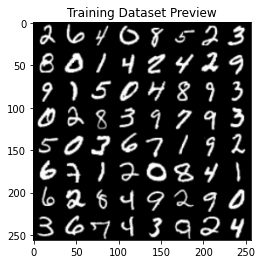

In [90]:
preview_dataloader(train_loader)

Images Shape: torch.Size([64, 1, 32, 32])
Label Shape: torch.Size([64])
First row labels
[7, 2, 1, 0, 4, 1, 4, 9]


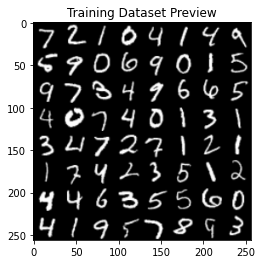

In [91]:
preview_dataloader(validation_loader)

## Initialize Model

### Gradient Origin Network

In [121]:
# create the GON network
class Generator(nn.Module):
    def __init__(self, kernel_size=4):
        super(Generator, self).__init__()
        # self.main = nn.Sequential(
        #     nn.ConvTranspose2d(nz, ngf * 4, kernel_size=kernel_size, stride=1, padding=0, bias=True),
        #     nn.BatchNorm2d(ngf * 4),
        #     nn.ELU(),
        #     nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=kernel_size, stride=2, padding=1, bias=True),
        #     nn.BatchNorm2d(ngf * 2),
        #     nn.ELU(),
        #     nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=kernel_size, stride=2, padding=1, bias=True),
        #     nn.BatchNorm2d(ngf),
        #     nn.ELU(),
        #     nn.ConvTranspose2d(ngf, n_channels, kernel_size=kernel_size, stride=2, padding=1, bias=True),
        #     nn.Sigmoid()
        # )

        self.layer1 = nn.Sequential(nn.ConvTranspose2d(nz, ngf * 4, kernel_size=kernel_size, stride=1, padding=0, output_padding=(4-kernel_size), bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=kernel_size, stride=2, padding=1, output_padding=(4-kernel_size), bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=kernel_size, stride=2, padding=1, output_padding=(4-kernel_size), bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(ngf, n_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=(4-kernel_size), bias=True),
            nn.Sigmoid())
 

    def forward(self, input):
        # print(input.shape)
        x = self.layer1(input)
        # print(x.shape)
        x = self.layer2(x)
        # print(x.shape)
        x = self.layer3(x)
        # print(x.shape)
        x = self.layer4(x)
        # print(x.shape)
        return x

## Train Model

### Training Helper Functions

In [98]:
def backup_network(net):
  global backup_folder, backup_name
  if not os.path.isdir(backup_folder):
    print('Unable to backup due to invalid backup folder. Please verify the folder path')
    return
  network_file_path = f'{backup_folder}/{backup_name}.pth'
  torch.save(net.state_dict(), network_file_path)
  print(f'Back up model to: {network_file_path}')

In [99]:
def slerp(a, b, t):
    omega = torch.acos((a/torch.norm(a, dim=1, keepdim=True)*b/torch.norm(b, dim=1, keepdim=True)).sum(1)).unsqueeze(1)
    res = (torch.sin((1.0-t)*omega)/torch.sin(omega))*a + (torch.sin(t*omega)/torch.sin(omega)) * b
    return res

def slerp_batch(model, z):
    lz = z.data.clone().squeeze(-1).squeeze(-1)
    col_size = int(np.sqrt(z.size(0)))
    src_z = lz.data[:col_size].repeat(col_size,1)
    z1, z2 = lz.data.split(lz.shape[0]//2)
    tgt_z = torch.cat([z2, z1])
    tgt_z = tgt_z[:col_size].repeat(col_size,1)
    t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).contiguous().view(batch_size,1).contiguous().to(device)
    z_slerp = slerp(src_z, tgt_z, t)
    g_slerp = model(z_slerp.unsqueeze(-1).unsqueeze(-1))
    return g_slerp

In [100]:
def show_recon(net, imgs, g, z):
  # plot reconstructions and interpolations
  clear_output()
  input_imgs = torchvision.utils.make_grid(imgs, padding=0, nrow=8)
  recons = torchvision.utils.make_grid(torch.clamp(g, 0, 1), padding=0, nrow=8)
  slerps = torchvision.utils.make_grid(torch.clamp(slerp_batch(net, z.data), 0, 1), padding=0, nrow=8)
  plt.title('Input Images')
  plt.imshow(input_imgs[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
  plt.figure()
  plt.title('Reconstructions')
  plt.imshow(recons[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
  plt.figure()
  plt.title('Spherical Interpolations')
  plt.imshow(slerps[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
  plt.show()
  sleep(1)

In [101]:
def compute_zero_gradient(net, imgs):
  z = torch.zeros(imgs.shape[0], nz, 1, 1).to(device).requires_grad_()
  g = net(z)
  L_inner = ((g - imgs)**2).sum(1).mean()
  grad = torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
  return -grad

def validate_network(net):
  validation_loss = 0.0
  for imgs, _ in tqdm(validation_loader):
    imgs = imgs.to(device)
    z = compute_zero_gradient(net,imgs)
    g = net(z)
    loss = ((g - imgs)**2).sum(1).mean()
    validation_loss += loss.item()
  validation_loss = validation_loss / len(validation_loader)
  return validation_loss

def train_gradient_origin_network(net, optim, epoch = 10, should_show_recon = False):
  validation_losses = []
  for e in tqdm(range(epoch), position=0, leave=False):
    L_outer, g = None, None
    for i, (imgs, _) in enumerate(tqdm(train_loader,position=1, leave=True)):
      imgs = imgs.to(device)
      # compute the gradients of the inner loss with respect to zeros (gradient origin)
      z = compute_zero_gradient(net,imgs)
      # now with z as our new latent points, optimise the data fitting loss
      g = net(z)
      L_outer = ((g - imgs)**2).sum(1).mean()
      optim.zero_grad()
      L_outer.backward()
      optim.step()
      if should_show_recon and i % 100 == 0: 
        show_recon(net, imgs.cpu(), g, z)
    backup_network(net)
    validation_loss = validate_network(net)
    print(f"Epoch: {e} Loss: {validation_loss:.4f}")
    validation_losses.append(validation_loss)
  return net, validation_losses


### Training the Network


In [ ]:
net = Generator().to(device)
optim = torch.optim.Adam(lr=lr, params=net.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(net.parameters()))}')
# validate_network(net)
net, losses = train_gradient_origin_network(net, optim, epoch=100)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.0387


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.0292


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.0226


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.0211


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.0039


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.0170


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.0047


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.0039


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.0034


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.0030


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.0311


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.0051


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.0040


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.0035


  0%|          | 0/937 [00:00<?, ?it/s]

Back up model to: /content/drive/My Drive/data/backup/GON-temp.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.0031


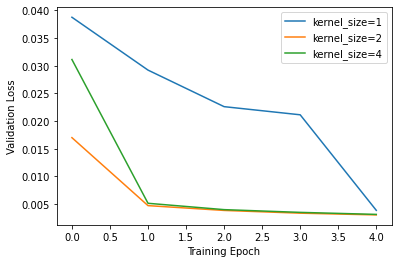

In [122]:
def experiment1_kernel_size():
    validation_losses = []
    sizes = [1,2,4]
    for i in sizes:
        kernel_size = 4
        net = Generator(kernel_size).to(device)
        optim = torch.optim.Adam(lr=lr, params=net.parameters())
        net, losses = train_gradient_origin_network(net, optim, epoch=5)
        validation_losses.append(losses)

    return validation_losses
        
validation_losses = experiment1_kernel_size()

plt.plot(range(len(validation_losses[0])), validation_losses[0], label = 'kernel_size=1')
plt.plot(range(len(validation_losses[1])), validation_losses[1], label = 'kernel_size=2')
plt.plot(range(len(validation_losses[2])), validation_losses[2], label = 'kernel_size=4')
# plt.plot(range(len(validation_losses[3])), validation_losses[3], label = 'kernel_size=4')
plt.title('')
plt.xlabel('Training Epoch')
plt.ylabel('Validation Loss')
plt.legend(loc="upper right")
plt.show()


In [ ]:
plt.title('Validation Loss per Epoch on CIRAF10 Dataset')
plt.xlabel('Training Epoch')
plt.ylabel('Validation Loss')
plt.plot(range(1,101), losses, 'b-')

### Continue Training

Load previously trained network

In [ ]:
net, optim = None, None
if os.path.isfile(f'{backup_folder}/{backup_name}.pth'):
  net.load_state_dict(torch.load(f'{backup_folder}/{backup_name}.pth'))
  optim = torch.optim.Adam(lr=lr, params=net.parameters())

Continue Training

In [ ]:
losses = None
if net is not None:
  net, losses = train_gradient_origin_network(net, epoch=10)

## Results

Regenerate the results from a given inputs

In [ ]:
def compare_output(loader):
  images, _ = next(iter(loader))
  z = compute_zero_gradient(net,imgs)
  g = net(z)
  input_imgs = torchvision.utils.make_grid(images, padding=0, nrow=8)
  recon_imgs = torchvision.utils.make_grid(torch.clamp(g, 0, 1), padding=0, nrow=8)
  plt.title('Testing Images')
  plt.imshow(input_imgs[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
  plt.figure()
  plt.title('Reconstructions')
  plt.imshow(recons[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
  plt.show()
  sleep(1)